## This notebook is for plotting violin plots of the total sediment basket weights a GSD 

Importing the data:

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
spring = pd.read_csv('spring2023_GSD.csv')
summer = pd.read_csv('summer2023_GSD.csv')

In [2]:
# Melt your DataFrame to long format
spring_melted = spring.melt(id_vars='Size', var_name='Sample', value_name='Percentage')
summer_melted = summer.melt(id_vars='Size', var_name='Sample', value_name='Percentage')
# Create a new DataFrame for total weights
spring_weights = spring[spring['Size'].isin(['WEIGHT'])].melt(id_vars='Size', var_name='Sample', value_name='Weight')
summer_weights = summer[summer['Size'].isin(['WEIGHT'])].melt(id_vars='Size', var_name='Sample', value_name='Weight')

Bar plot comparing different weights

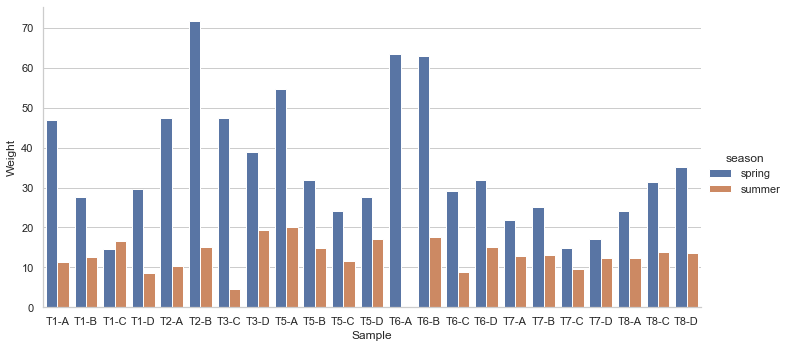

In [4]:
# Add a new column to indicate the season
spring_weights['season'] = 'spring'
summer_weights['season'] = 'summer'

# Concatenate the two dataframes
weights = pd.concat([spring_weights, summer_weights])

# Create the bar plot
sns.set_theme(style="whitegrid")
sns.catplot(data=weights, x='Sample', y='Weight', hue='season', kind='bar', height=5, aspect=2)

plt.show()

<AxesSubplot: xlabel='day', ylabel='total_bill'>

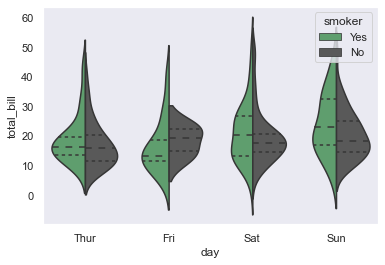

In [5]:
# testing how the violin plot works
sns.set_theme(style="dark")

# load the example tips dataset
tips = sns.load_dataset("tips")

# draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=tips, x="day", y="total_bill", hue="smoker",
            split=True, inner="quart", fill=False,
            palette={"Yes": "g", "No": ".35"})

Converting data for violin plots

In [6]:
# get spring data
num_points = 1000
samples = []

for basket in spring.columns:
    if basket != 'Size':
        spring[basket+'_quantity'] = spring[basket] * num_points
        repeated_values = np.repeat(spring['Size'][:-2], spring[basket+'_quantity'][:-2])
        basket_ids = [basket] * len(repeated_values)
        samples.append(pd.DataFrame({
            'value': repeated_values,
            'basket_id': basket_ids
        }))

# concatenate all the df in the list into a single spring dataframe
samples_spring = pd.concat(samples, ignore_index=True)
samples_spring['season'] = 'spring' 

# do the same for the summer
num_points = 1000
samples = []

for basket in summer.columns:
    if basket != 'Size':
        summer[basket+'_quantity'] = summer[basket] * num_points
        repeated_values = np.repeat(summer['Size'][:-2], summer[basket+'_quantity'][:-2])
        basket_ids = [basket] * len(repeated_values)
        samples.append(pd.DataFrame({
            'value': repeated_values,
            'basket_id': basket_ids
        }))

# concatenate all the df in the list into a single summer dataframe
samples_summer = pd.concat(samples, ignore_index=True)
samples_summer['season'] = 'summer' 

# concatenate the two dataframes
samples = pd.concat([samples_spring, samples_summer], ignore_index=True)


### Violin plots

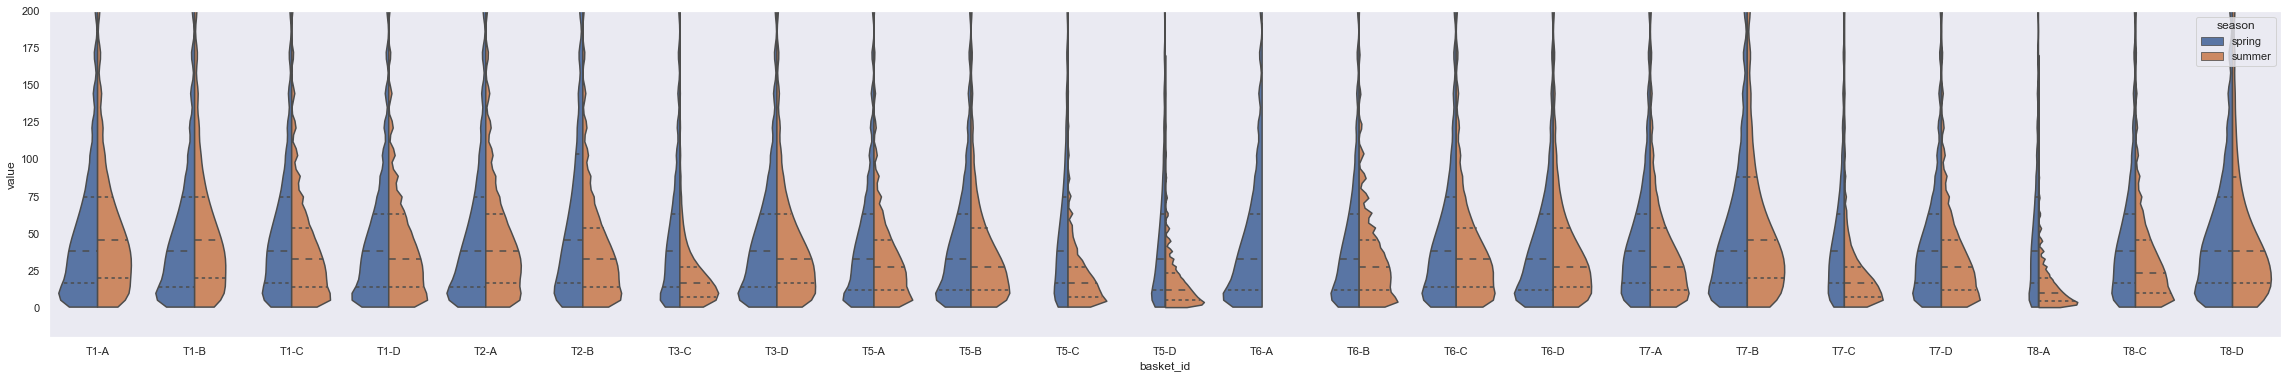

In [12]:
samples['value'] = samples['value'].astype(float)

plt.figure(figsize=(40, 6))
# draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=samples, x="basket_id", y="value", hue="season",
                    split=True, inner="quart", fill=False, cut=0)
ax.set_ylim(-20, 200)
plt.savefig('violin_plot.png')
plt.show()

In [15]:
# separate between open and closed basket (A and D are closed, B and C are open)
samples['basket_type'] = samples['basket_id'].apply(lambda x: 'closed' if x[-1] in ['A', 'D'] else 'open')
# create two different dataframes for it 
open_samples = samples[samples['basket_type'] == 'open']
closed_samples = samples[samples['basket_type'] == 'closed']

Open baskets

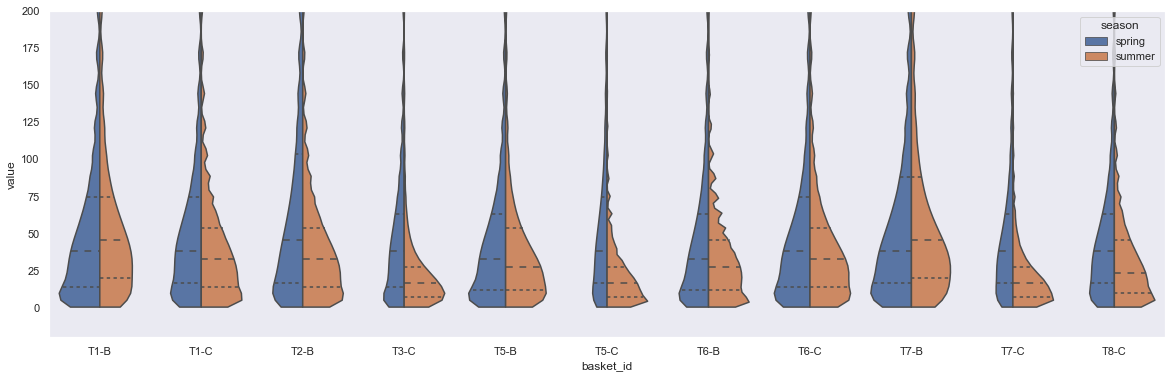

In [16]:
plt.figure(figsize=(20, 6))
# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=open_samples, x="basket_id", y="value", hue="season",
                    split=True, inner="quart", fill=False, cut=0)
ax.set_ylim(-20, 200)
ax.set_title('Open baskets Grain Size Distribution')
plt.savefig('violin_plot_open.png')
plt.show()

Testing Stuff

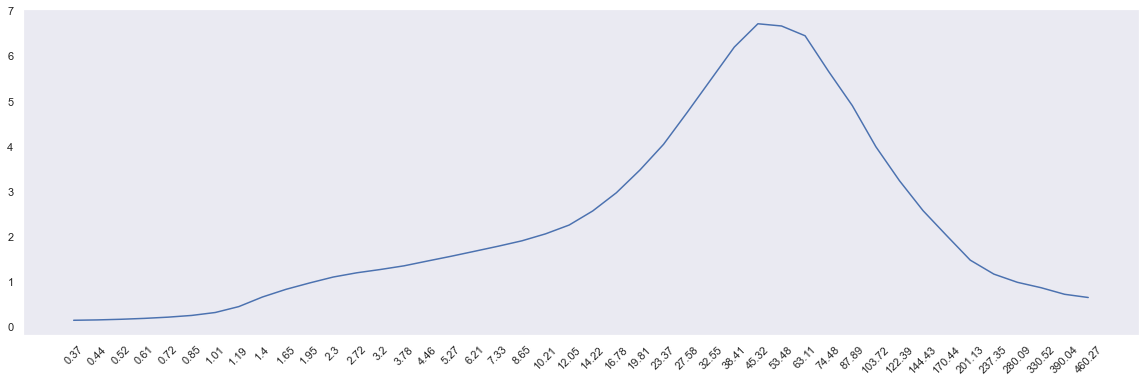

In [40]:
plt.figure(figsize=(20, 6))
plt.plot(spring['Size'][:-2], spring['T1-A'][:-2], label='T1-A')
plt.xticks(rotation=45)
#ax.set_xscale('log')
plt.show()

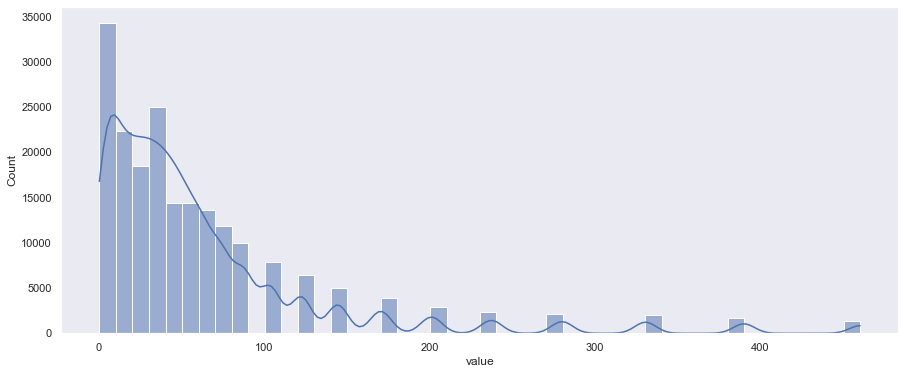

In [41]:
T1A = samples[samples['basket_id'] == 'T1-A']
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=T1A, x="value", binwidth=10, kde=True)
#ax.set_xscale('log')

esta weá está re mala

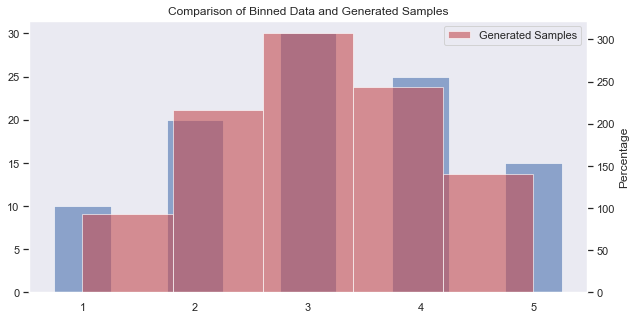

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Example binned data (replace with your actual data)
sizes = np.array([1, 2, 3, 4, 5])  # Grain sizes
percentages = np.array([10, 20, 30, 25, 15])  # Corresponding percentages

# Number of samples you want to generate
num_samples = 1000

# Generate samples
samples = np.random.choice(sizes, size=num_samples, p=percentages/100)

# Plotting the binned data
plt.figure(figsize=(10, 5))
plt.bar(sizes, percentages, width=0.5, color='b', alpha=0.6, label='Binned Data')
plt.twinx()

# Plotting the generated samples
plt.hist(samples, bins=len(sizes), color='r', alpha=0.6, label='Generated Samples', align='mid')

# Adding labels and title
plt.xlabel('Grain Size')
plt.ylabel('Percentage')
plt.title('Comparison of Binned Data and Generated Samples')
plt.legend()

# Show plot
plt.show()

In [105]:
# load your data
df = spring.copy()

# convert 'Size (um)' column to numeric
sizes = pd.to_numeric(df.iloc[:-2, 0].values, errors='coerce')
percentages = df.iloc[:-2, 1].astype(float).values

num_samples = 10000000 # number of random samples to generate

# Generate the samples
random_samples = np.random.choice(sizes, size=num_samples, p=percentages/percentages.sum())

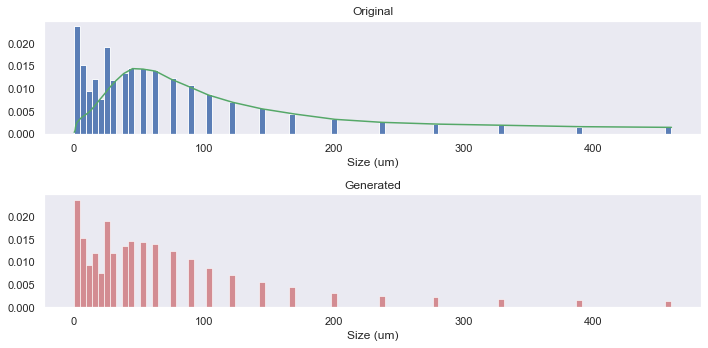

In [118]:
fig, axs = plt.subplots(2, figsize=(10, 5))

# original data
bin_width = np.diff(sizes).mean()  # approximate bin width
axs[0].hist(sizes, weights=percentages, bins=100, alpha=0.9, label='Original', color='b', density=True)
axs[0].plot(sizes, percentages/5000 * bin_width, color='g')  # line plot
axs[0].set_title('Original')
axs[0].set_xlabel('Size (um)')

# generated samples
axs[1].hist(random_samples, bins=100, alpha=0.6, label='Generated', color='r', density=True)
axs[1].set_title('Generated')
axs[1].set_xlabel('Size (um)')

plt.tight_layout()
plt.show()

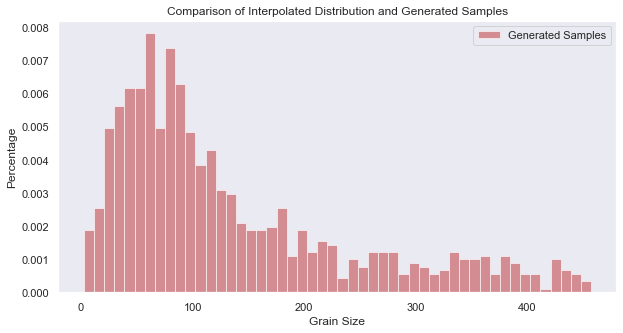

In [121]:
from scipy.interpolate import interp1d
# define a regular grid of grain sizes
regular_sizes = np.linspace(sizes.min(), sizes.max(), 1000)

# interpolate percentages onto the regular grid
interp_func = interp1d(sizes, percentages, kind='linear')
regular_percentages = interp_func(regular_sizes)
# normalize percentages to sum up to 100 
regular_percentages /= regular_percentages.sum() * 100 



# Number of samples you want to generate
num_samples = 1000
# Generate samples
samples = np.random.choice(regular_sizes, size=num_samples, p=regular_percentages/regular_percentages.sum())

# Plotting the interpolated distribution
plt.figure(figsize=(10, 5))
#plt.plot(regular_sizes, regular_percentages, color='b', label='Interpolated Distribution')

# Plotting the generated samples
#plt.hist(samples, bins=50, color='r', alpha=0.6, label='Generated Samples', density=True)

# Adding labels and title
plt.xlabel('Grain Size')
plt.ylabel('Percentage')
plt.title('Comparison of Interpolated Distribution and Generated Samples')
plt.legend()

# Show plot
plt.show()

In [130]:
sizes

array([3.7000e-01, 4.4000e-01, 5.2000e-01, 6.1000e-01, 7.2000e-01,
       8.5000e-01, 1.0100e+00, 1.1900e+00, 1.4000e+00, 1.6500e+00,
       1.9500e+00, 2.3000e+00, 2.7200e+00, 3.2000e+00, 3.7800e+00,
       4.4600e+00, 5.2700e+00, 6.2100e+00, 7.3300e+00, 8.6500e+00,
       1.0210e+01, 1.2050e+01, 1.4220e+01, 1.6780e+01, 1.9810e+01,
       2.3370e+01, 2.7580e+01, 3.2550e+01, 3.8410e+01, 4.5320e+01,
       5.3480e+01, 6.3110e+01, 7.4480e+01, 8.7890e+01, 1.0372e+02,
       1.2239e+02, 1.4443e+02, 1.7044e+02, 2.0113e+02, 2.3735e+02,
       2.8009e+02, 3.3052e+02, 3.9004e+02, 4.6027e+02])

In [124]:
regular_percentages

array([0.158     , 0.25925918, 0.56267997, 0.89050811, 1.0818538 ,
       1.19821278, 1.271683  , 1.3368178 , 1.40593892, 1.4769019 ,
       1.53657824, 1.5943617 , 1.6487234 , 1.70046847, 1.7465045 ,
       1.79254054, 1.8345804 , 1.87608258, 1.91764033, 1.96308616,
       2.00853199, 2.05397782, 2.1015141 , 2.15030229, 2.19909048,
       2.24787867, 2.30760518, 2.37379524, 2.4399853 , 2.50617536,
       2.57236543, 2.64413704, 2.716428  , 2.78871896, 2.86100992,
       2.93330089, 3.00710838, 3.08368317, 3.16025796, 3.23683275,
       3.31340755, 3.38998234, 3.46655713, 3.54071951, 3.61417026,
       3.68762101, 3.76107177, 3.83452252, 3.90797328, 3.98142403,
       4.05501727, 4.13210849, 4.20919972, 4.28629094, 4.36338217,
       4.44047339, 4.51756461, 4.59465584, 4.67174706, 4.74883829,
       4.81696259, 4.88402514, 4.9510877 , 5.01815025, 5.08521281,
       5.15227536, 5.21933792, 5.28640047, 5.35346303, 5.42052559,
       5.48658755, 5.54346484, 5.60034213, 5.65721941, 5.71409

In [125]:
sum(regular_percentages)

2150.8656085916805

In [129]:
sum([5.0, 7.5, 10.0, 12.5, 15.0, 10.0, 7.5, 5.0, 5.0, 2.5, 
                        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
                        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
                        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
                        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])

175.0

In [128]:
sum(a)

2281.8721197759396